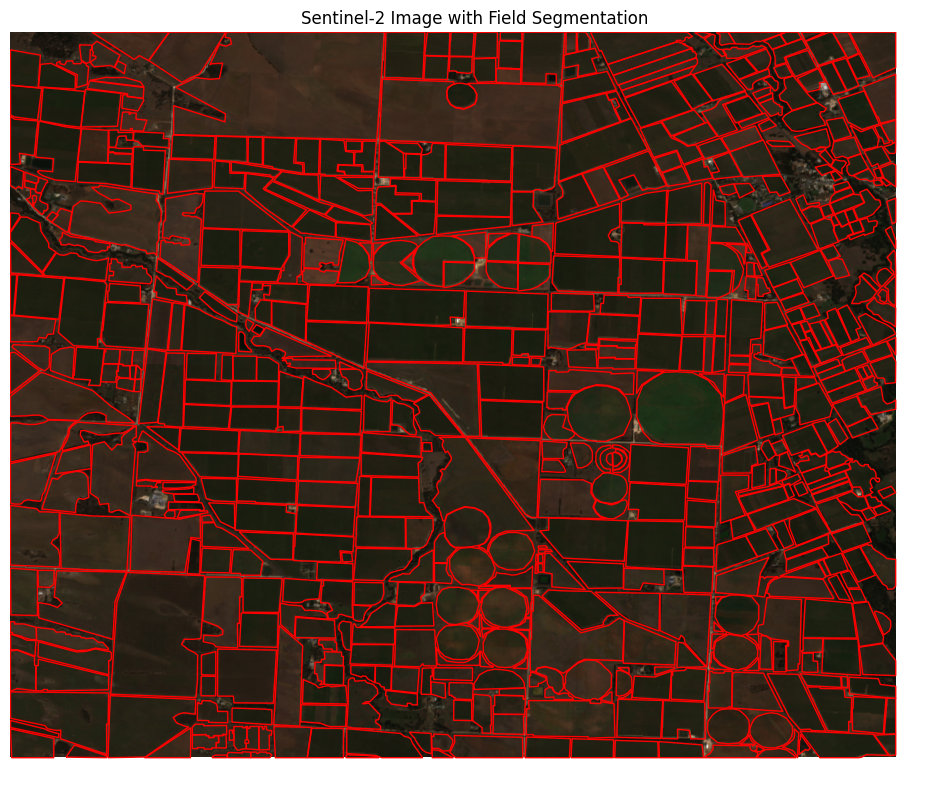

In [4]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json
from shapely.geometry import Polygon

def load_satellite_image(image_path):
    with rasterio.open(image_path) as src:
        return src.read(), src.meta

def load_annotations(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def create_polygon(coordinates):
    # Reshape the coordinates into pairs
    coords = np.array(coordinates).reshape(-1, 2)
    return Polygon(coords)

def visualize_dataset(image_path, annotation_path):
    # Load satellite image
    image, meta = load_satellite_image(image_path)
    
    # Load annotations
    annotations = load_annotations(annotation_path)
    
    # Find the correct image annotations
    image_name = image_path.split('/')[-1]
    image_annotations = next(img for img in annotations['images'] if img['file_name'] == image_name)
    
    # Create polygons from the annotations
    polygons = [create_polygon(ann['segmentation']) for ann in image_annotations['annotations']]
    gdf = gpd.GeoDataFrame(geometry=polygons)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Display the satellite image (using RGB bands)
    rgb_bands = [3, 2, 1]  # Assuming B4=Red, B3=Green, B2=Blue
    rgb_image = np.dstack([image[i] for i in rgb_bands])
    rgb_image = (rgb_image / rgb_image.max() * 255).astype(np.uint8)
    ax.imshow(rgb_image)
    
    # Plot the polygons
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')
    
    plt.title('Sentinel-2 Image with Field Segmentation')
    plt.axis('off')
    plt.show()



visualize_dataset('train_images/images/train_0.tif', 'train_annotation.json')

Image dimensions: 952x804
Number of bands: 12


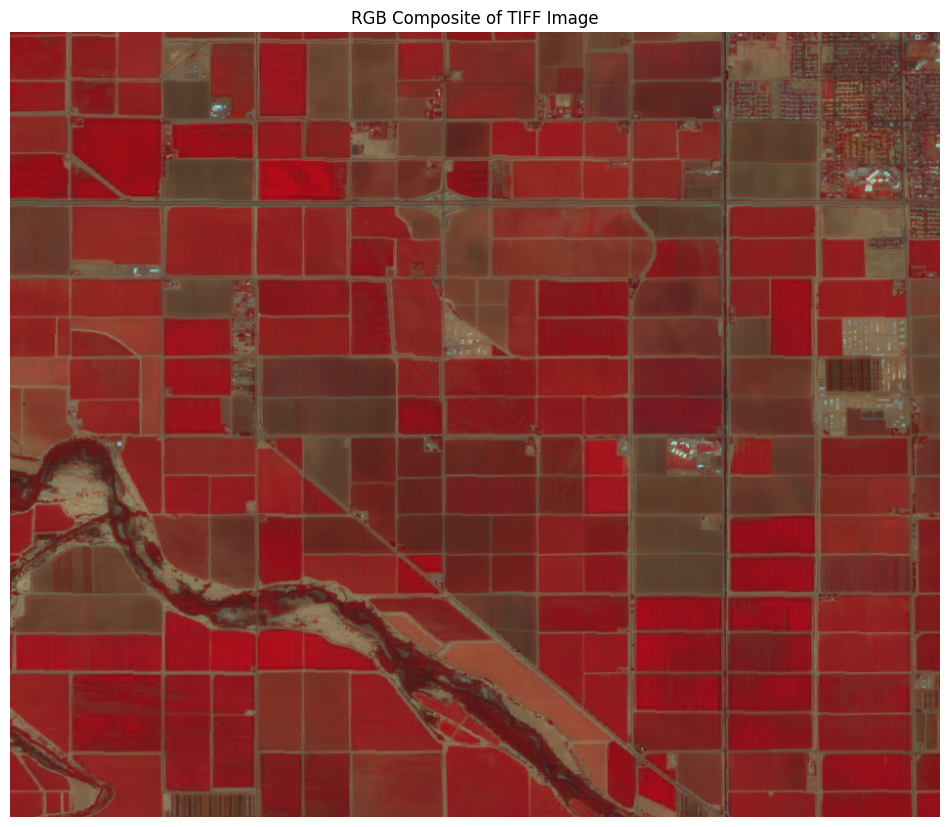

In [5]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def display_tiff(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        
        height = src.height
        width = src.width
        bands = src.count
        
        print(f"Image dimensions: {width}x{height}")
        print(f"Number of bands: {bands}")
        
        # If the image has more than 3 bands, we'll use the first three for RGB display
        if bands >= 3:
            # Assuming the first three bands correspond to RGB
            rgb_bands = [3,2,1]  # Remember, rasterio uses 1-based indexing, but numpy uses 0-based
            rgb_image = np.dstack([image[i] for i in rgb_bands])
            
            # Normalize the data to 0-255 for display
            rgb_image = (rgb_image / rgb_image.max() * 255).astype(np.uint8)
            
            plt.figure(figsize=(12, 12))
            plt.imshow(rgb_image)
            plt.axis('off')
            plt.title('RGB Composite of TIFF Image')
            plt.show()
        else:
            print("The image has fewer than 3 bands. Displaying first band as grayscale.")
            plt.figure(figsize=(12, 12))
            plt.imshow(image[0], cmap='gray')
            plt.axis('off')
            plt.title('First Band of TIFF Image (Grayscale)')
            plt.show()

display_tiff('train_images/images/train_3.tif')

Image dimensions: 952x804
Number of bands: 12


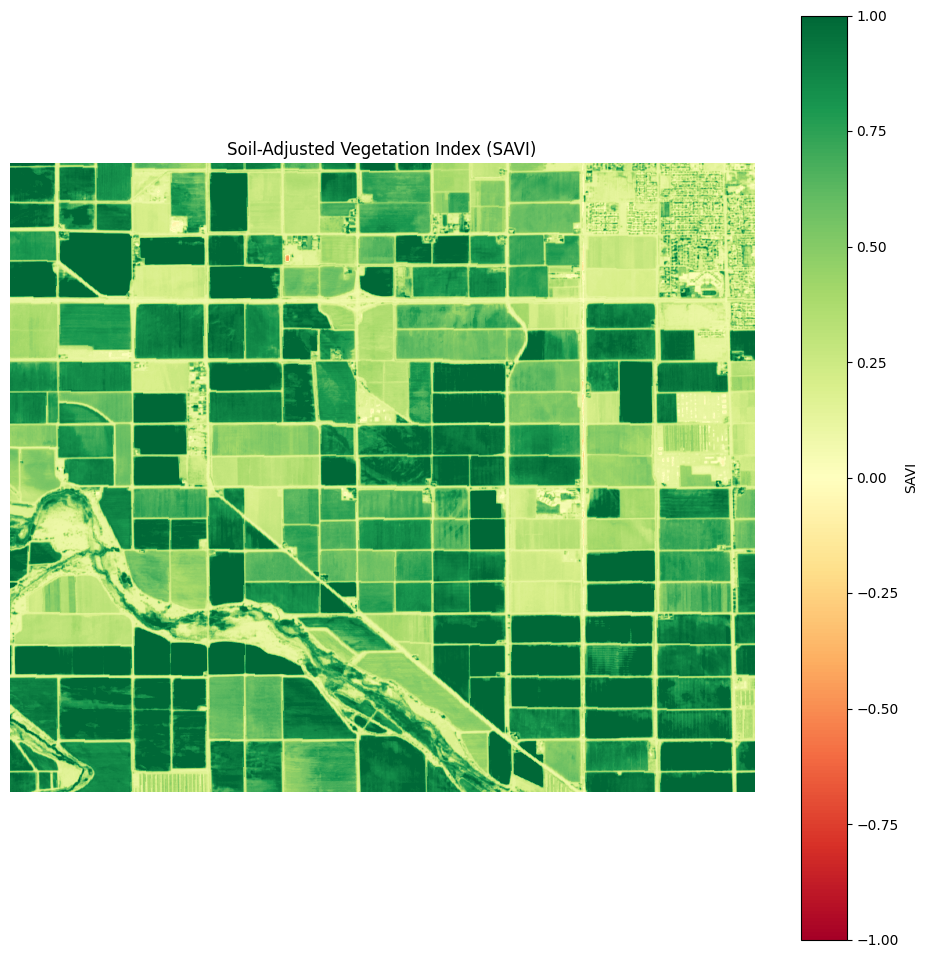

In [4]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def display_tiff(image_path, index='NDVI'):
    with rasterio.open(image_path) as src:
        image = src.read()
        
        height = src.height
        width = src.width
        bands = src.count
        
        print(f"Image dimensions: {width}x{height}")
        print(f"Number of bands: {bands}")
        
        # Ensure we have the necessary bands for NDVI or SAVI
        if bands < 8:
            print("The image doesn't have enough bands for NDVI or SAVI calculation.")
            return
        
        # Extract bands 4 (Red) and 8 (NIR)
        red = image[3].astype(float)  # B4
        nir = image[7].astype(float)  # B8
        
        # Calculate the chosen index
        if index == 'NDVI':
            result = (nir - red) / (nir + red)
            title = 'Normalized Difference Vegetation Index (NDVI)'
        elif index == 'SAVI':
            L = 0.5  # soil brightness correction factor
            result = ((nir - red) / (nir + red + L)) * (1 + L)
            title = 'Soil-Adjusted Vegetation Index (SAVI)'
        else:
            print("Invalid index. Choose 'NDVI' or 'SAVI'.")
            return
        
        # Create a colormap
        cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap
        
        # Plot the result
        plt.figure(figsize=(12, 12))
        im = plt.imshow(result, cmap=cmap, vmin=-1, vmax=1)
        plt.colorbar(im, label=index)
        plt.axis('off')
        plt.title(title)
        plt.show()

# Example usage:
display_tiff('train_images/images/train_3.tif', index='SAVI')
# To use SAVI instead, use:
# display_tiff('train_images/images/train_3.tif', index='SAVI')

Image dimensions: 952x804
Number of bands: 12


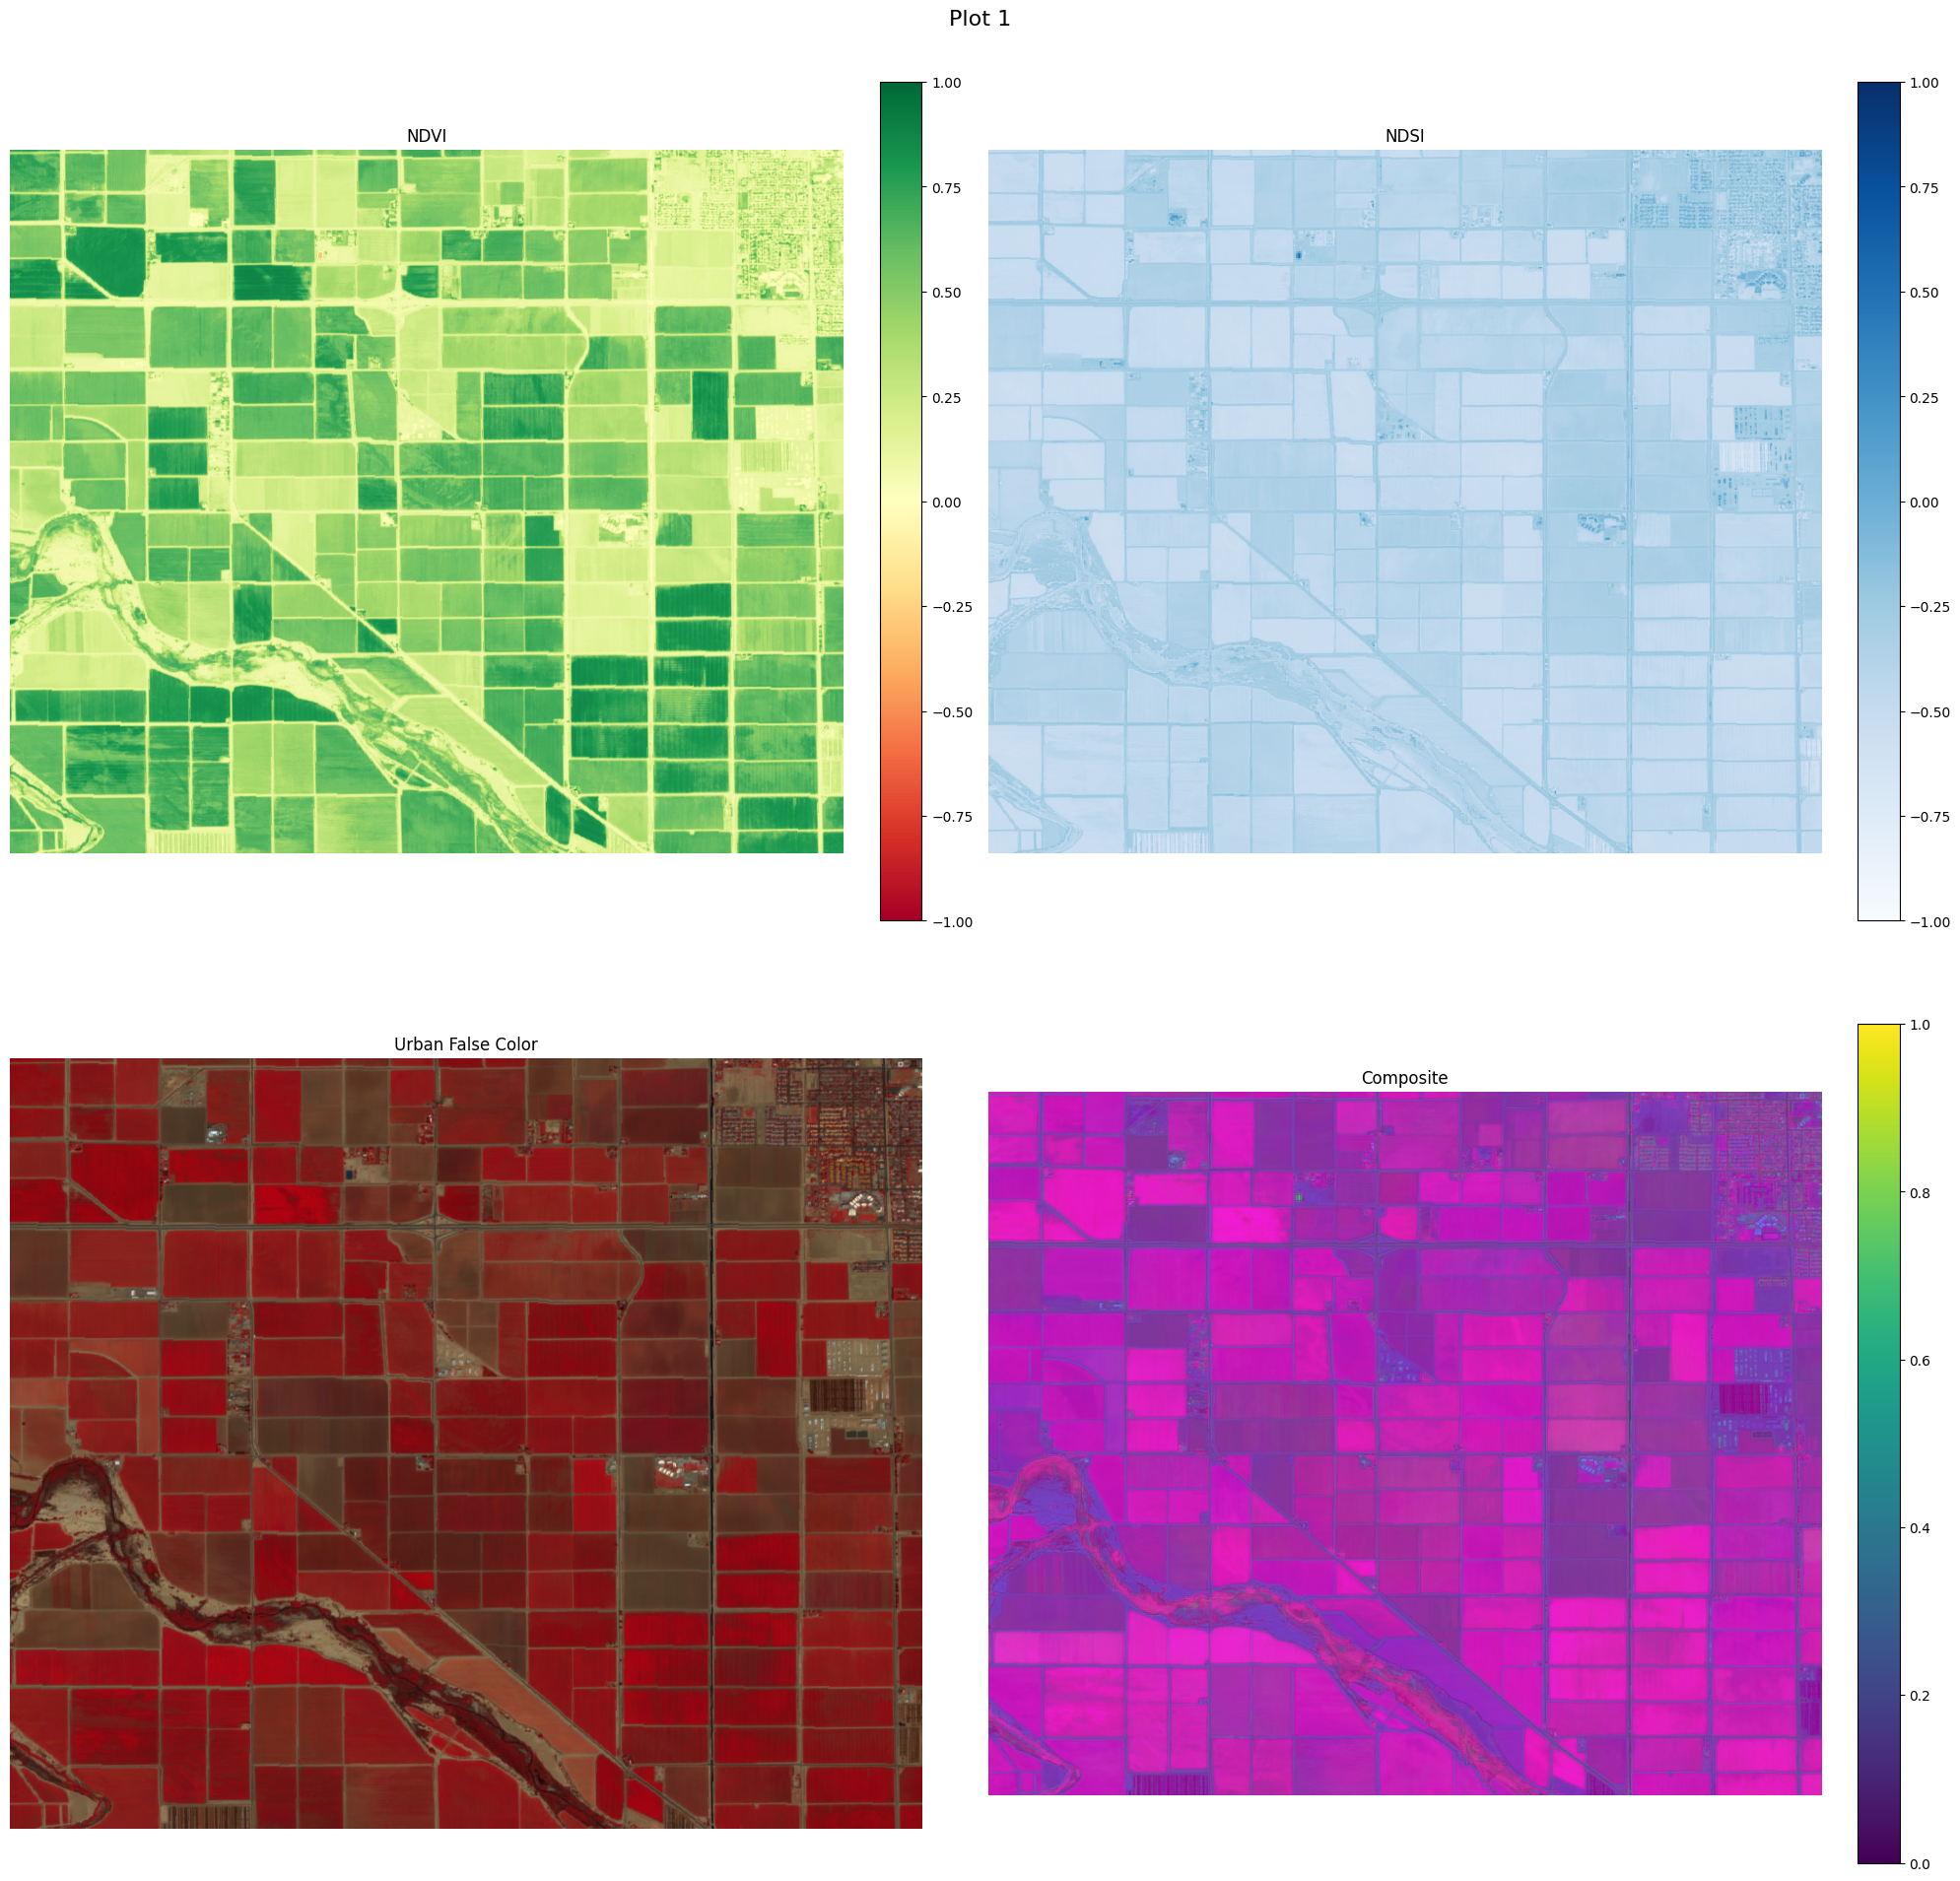

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def display_multi_indices(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        
        height = src.height
        width = src.width
        bands = src.count
        
        print(f"Image dimensions: {width}x{height}")
        print(f"Number of bands: {bands}")
        
        # Ensure we have the necessary bands
        if bands < 12:
            print("The image doesn't have enough bands for the required calculations.")
            return
        
        # Extract required bands
        blue = image[1].astype(float)    # B2
        green = image[2].astype(float)   # B3
        red = image[3].astype(float)     # B4
        nir = image[7].astype(float)     # B8
        swir1 = image[10].astype(float)  # B11
        
        # Calculate NDVI
        ndvi = (nir - red) / (nir + red)
        
        # Calculate NDSI (Normalized Difference Snow Index)
        ndsi = (green - swir1) / (green + swir1)
        
        # Urban False Color (using NIR, Red, Green)
        urban_false_color = np.dstack((nir, red, green))
        
        # Normalize the false color image
        urban_false_color = (urban_false_color - urban_false_color.min()) / (urban_false_color.max() - urban_false_color.min())
        
        # Create a composite image
        composite = np.dstack((ndvi, ndsi, urban_false_color[:,:,0]))
        composite = (composite - composite.min()) / (composite.max() - composite.min())
        
        # Plot the results
        fig, axs = plt.subplots(2, 2, figsize=(20, 20))
        fig.suptitle('Plot 1', fontsize=16)
        
        im1 = axs[0, 0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
        axs[0, 0].set_title('NDVI')
        plt.colorbar(im1, ax=axs[0, 0], fraction=0.046, pad=0.04)
        
        im2 = axs[0, 1].imshow(ndsi, cmap='Blues', vmin=-1, vmax=1)
        axs[0, 1].set_title('NDSI')
        plt.colorbar(im2, ax=axs[0, 1], fraction=0.046, pad=0.04)
        
        axs[1, 0].imshow(urban_false_color)
        axs[1, 0].set_title('Urban False Color')
        
        im4 = axs[1, 1].imshow(composite)
        axs[1, 1].set_title('Composite')
        plt.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04)
        
        for ax in axs.flat:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage:
display_multi_indices('train_images/images/train_3.tif')

In [11]:
import os
import tifffile
import numpy as np
from collections import defaultdict

def analyze_tif_images(folder_path):
    # Dictionary to store image count for each size
    size_count = defaultdict(int)
    
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter for TIF files
    tif_files = [f for f in files if f.lower().endswith('.tif') or f.lower().endswith('.tiff')]
    
    # Analyze each image
    for tif_file in tif_files:
        try:
            with tifffile.TiffFile(os.path.join(folder_path, tif_file)) as tif:
                # Get the shape of the first series
                series = tif.series[0]
                shape = series.shape
                
                # Check if it's a 12-channel image
                if len(shape) == 3 and shape[0] == 11:
                    height, width = shape[1], shape[2]
                    size_count[(width, height)] += 1
                else:
                    print(f"Shape: {shape}")
        except Exception as e:
            print(f"Error processing {tif_file}: {str(e)}")
    
    # Print results
    total_images = sum(size_count.values())
    print(f"Total 12-channel TIF images analyzed: {total_images}")
    print("\nImage size distribution:")
    for size, count in size_count.items():
        print(f"{count} images are {size[0]}x{size[1]}")
# Example usage
folder_path = "train_images/images"
analyze_tif_images(folder_path)

Shape: (803, 1053, 12)
Shape: (803, 1063, 12)
Shape: (801, 1293, 12)
Shape: (802, 1170, 12)
Shape: (804, 930, 12)
Shape: (802, 1167, 12)
Shape: (803, 1061, 12)
Shape: (804, 1034, 12)
Shape: (804, 953, 12)
Shape: (804, 904, 12)
Shape: (801, 1324, 12)
Shape: (802, 1176, 12)
Shape: (802, 1169, 12)
Shape: (804, 928, 12)
Shape: (804, 952, 12)
Shape: (805, 914, 12)
Shape: (802, 1314, 12)
Shape: (804, 928, 12)
Shape: (802, 1206, 12)
Shape: (804, 929, 12)
Shape: (804, 978, 12)
Shape: (803, 1067, 12)
Shape: (804, 909, 12)
Shape: (804, 981, 12)
Shape: (803, 1090, 12)
Shape: (804, 984, 12)
Shape: (802, 1194, 12)
Shape: (802, 1179, 12)
Shape: (802, 1199, 12)
Shape: (803, 1002, 12)
Shape: (804, 948, 12)
Shape: (801, 1254, 12)
Shape: (802, 1179, 12)
Shape: (803, 1053, 12)
Shape: (803, 1061, 12)
Shape: (801, 1195, 12)
Shape: (802, 1082, 12)
Shape: (805, 882, 12)
Shape: (803, 1039, 12)
Shape: (802, 1288, 12)
Shape: (804, 976, 12)
Shape: (802, 1198, 12)
Shape: (803, 1036, 12)
Shape: (803, 1065, 12)
Sha